In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import sys
sys.path.append('..')
sys.path.append('../visualization')
sys.path.append('../dsets/sst')

import acd
import viz_1d as viz
from dsets.sst import dset
from dsets.sst.model import LSTMSentiment

# load model and vocab

In [2]:
device = 'cpu' # device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTMSentiment()
model.load_state_dict(torch.load('../dsets/sst/state_dict.pth'))
vocab = dset.load_vocab()

# generate hierarchical interpretation given text

/system/linux/anaconda3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


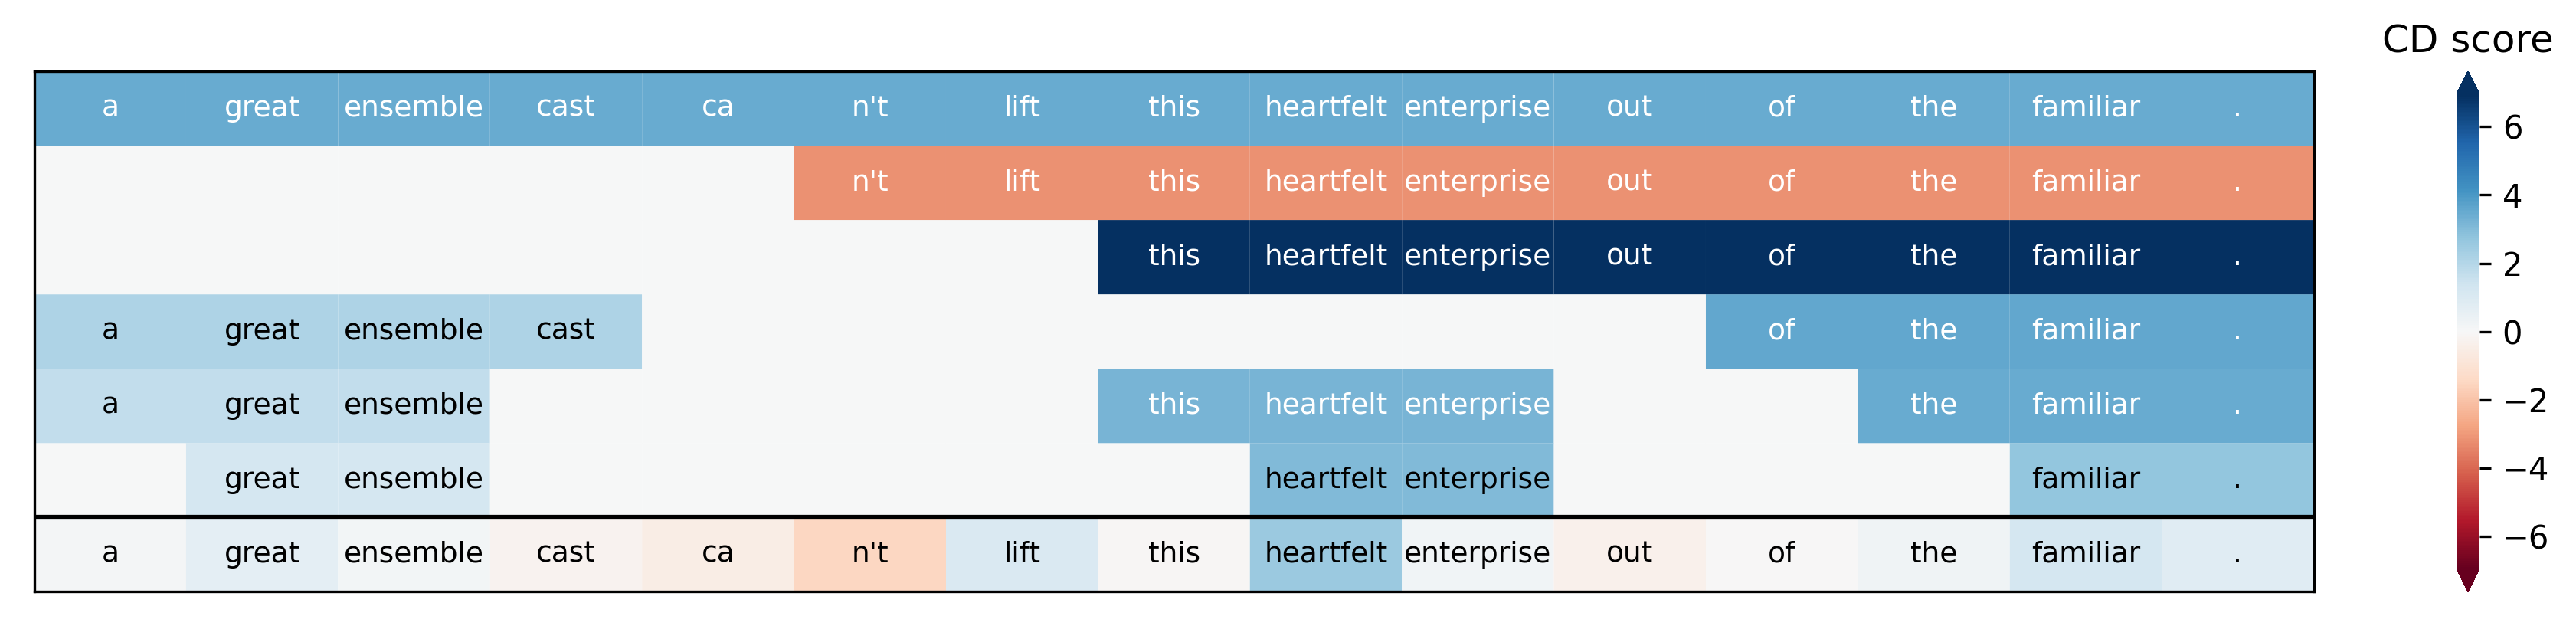

In [3]:
# hyperparameters
sweep_dim = 1 # how large chunks of text should be considered (1 for words)
method = 'cd' # build_up, break_down, cd
percentile_include = 99.5 # keep this very high so we don't add too many words at once
num_iters = 25 # maximum number of iterations (rarely reached)

# text and label
sentence = ['a', 'great', 'ensemble', 'cast', 'ca', 'n\'t', 'lift', 'this',
            'heartfelt', 'enterprise', 'out', 'of', 'the', 'familiar', '.'] # an example from SST
# sentence = ['not', 'good', ',', 'not', 'bad', ',', 'just', 'okay'] # any text with words from this dataset can be interpreted
label = 1 # 0 if positive 1 if negative

# prepare inputs
batch = dset.batch_from_str_list(sentence, vocab)
scores_all = model(batch).data.cpu().numpy()[0] # predict
label_pred = np.argmax(scores_all) # get predicted class

# agglomerate
lists = acd.agg_1d.agglomerate(model, batch, percentile_include, method, sweep_dim, # only works for sweep_dim = 1
                    label_pred, num_iters=num_iters, device=device) # see agg_1d.agglomerate to understand what this dictionary contains
lists = acd.agg_1d.collapse_tree(lists) # don't show redundant joins

# visualize
viz.word_heatmap(sentence, lists, label_pred, label, fontsize=9)